# Structural Identifiability Analysis of ODE Models
# A Computational Tutorial with Julia

**Author:** Abdallah Alsammani
**Affiliation:** Department of Mathematical Sciences, Delaware State University, Dover, DE, USA
**Contact:** aalsammani@desu.edu

---

## Overview

This notebook is the computational companion to the paper *"Structural Identifiability of Dynamical Models: A Geometric Framework with Computational Illustrations."*

Six examples of increasing complexity illustrate how the geometry of the parameter-to-output map $\Phi:\Theta\to\mathcal{Y}$ determines whether model parameters can be recovered from observations. For each example, we follow a systematic procedure:

1. **State the model** — dynamics, output equation, unknowns.
2. **Derive the coefficient map** $\Phi$ — via Taylor series or input-output equations.
3. **Compute the Jacobian** $D\Phi$ and its kernel.
4. **Classify every parameter** — SGI, SLI, or SNI.
5. **Identify the nonidentifiability manifold** (if present) and its geometric structure.
6. **Verify computationally** using `StructuralIdentifiability.jl`.
7. **Visualize** — fibers, manifolds, output equivalences.

All figures are rendered inline. The structural analysis uses the Julia package `StructuralIdentifiability.jl` (Dong et al., 2023).

## Table of Contents

**Foundations**
1. [Setup](#sec-setup)
2. [The Parameter-to-Output Map $\Phi$](#sec-framework)

**Examples**
3. [Example 1: First-Order Kinetics](#sec-ex1) — Direct vs. scaled observation
4. [Example 2: SIR Epidemic Model](#sec-ex2) — Observation determines identifiability
5. [Example 3: Two-Compartment Pharmacokinetics](#sec-ex3) — Biexponential output
6. [Example 4: Within-Host Viral Dynamics](#sec-ex4) — All three identifiability classes
7. [Example 5: SEIR with Hospitalization](#sec-ex5) — Staged algebraic resolution
8. [Example 6: Environmental Transmission](#sec-ex6) — Wastewater surveillance

**Connections**
9. [The Structural-to-Statistical Bridge](#sec-practical) — FIM and kernel containment
10. [Likelihood Geometry](#sec-asymptotic) — Four regimes
11. [Summary](#sec-summary)
12. [References](#sec-references)

---
## 1. Setup <a id="sec-setup"></a>

In [4]:
using Pkg
Pkg.add(["StructuralIdentifiability", "Plots", "LaTeXStrings", "StatsPlots"])

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\abdal\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\abdal\.julia\environments\v1.12\Manifest.toml`


In [5]:
using StructuralIdentifiability
using Plots; gr()
using StatsPlots
using LinearAlgebra
using LaTeXStrings

println("Packages loaded successfully.")
println("Julia version: ", VERSION)
println()
println("Key functions:")
println("  assess_local_identifiability(model)   — local (rank) test")
println("  assess_identifiability(model)          — global: SGI / SLI / SNI")
println("  find_identifiable_functions(model)     — maximal identifiable combinations")

Packages loaded successfully.
Julia version: 1.12.2

Key functions:
  assess_local_identifiability(model)   — local (rank) test
  assess_identifiability(model)          — global: SGI / SLI / SNI
  find_identifiable_functions(model)     — maximal identifiable combinations


---
## 2. The Parameter-to-Output Map $\Phi$ <a id="sec-framework"></a>

### The General ODE Model

$$\Sigma(\boldsymbol{\theta}): \quad \dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u}, \boldsymbol{\theta}), \quad \mathbf{y} = \mathbf{g}(\mathbf{x}, \boldsymbol{\theta}), \quad \mathbf{x}(0) = \mathbf{x}_0(\boldsymbol{\theta})$$

### The Coefficient Map

Differential algebra eliminates the state variables to produce input-output equations whose coefficients depend only on $\boldsymbol{\theta}$:

$$\Phi: \Theta \to \mathbb{R}^r, \quad \boldsymbol{\theta} \mapsto (c_1(\boldsymbol{\theta}), \ldots, c_r(\boldsymbol{\theta}))$$

### Identifiability as Fiber Geometry

| Classification | Fiber $\Phi^{-1}(\mathbf{c})$ | Jacobian $D\Phi$ | Consequence |
|---|---|---|---|
| **SGI** (globally identifiable) | Single point | Full rank, $\Phi$ injective | Unique recovery possible |
| **SLI** (locally identifiable) | Finite point set | Full rank, finite preimages | Discrete ambiguity |
| **SNI** (nonidentifiable) | Positive-dimensional variety | $\ker D\Phi \neq \{0\}$ | Individual recovery impossible |

### Kernel Containment (the structural-to-statistical bridge)

$$\ker D\Phi \subseteq \ker \mathcal{F}$$

where $\mathcal{F}$ is the Fisher information matrix. Every algebraic degeneracy (nontrivial kernel of $D\Phi$) manifests as a statistical degeneracy (zero eigenvalue of $\mathcal{F}$).

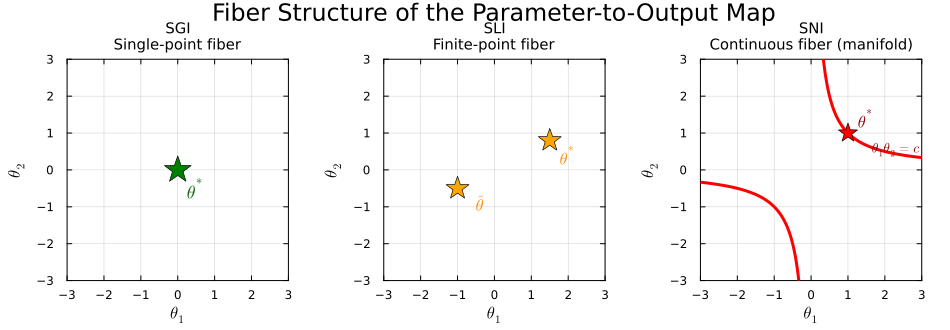

In [7]:
# ═══════════════════════════════════════════════════════════════
# Visualization: Three Types of Fiber Structure
# The fiber Phi^{-1}(c) determines the identifiability class.
# ═══════════════════════════════════════════════════════════════

p1 = plot(title="SGI\nSingle-point fiber",
    xlabel=L"\theta_1", ylabel=L"\theta_2", legend=false,
    aspect_ratio=1, xlim=(-3,3), ylim=(-3,3),
    grid=true, framestyle=:box, titlefontsize=10)
scatter!(p1, [0.0], [0.0], markersize=14, color=:green, markershape=:star5)
annotate!(p1, 0.5, -0.5, text(L"\theta^*", 12, :darkgreen))

p2 = plot(title="SLI\nFinite-point fiber",
    xlabel=L"\theta_1", ylabel=L"\theta_2", legend=false,
    aspect_ratio=1, xlim=(-3,3), ylim=(-3,3),
    grid=true, framestyle=:box, titlefontsize=10)
scatter!(p2, [1.5, -1.0], [0.8, -0.5], markersize=12, color=:orange, markershape=:star5)
annotate!(p2, 2.0, 0.4, text(L"\theta^*", 11, :darkorange))
annotate!(p2, -0.4, -0.9, text(L"\tilde{\theta}", 11, :darkorange))

p3 = plot(title="SNI\nContinuous fiber (manifold)",
    xlabel=L"\theta_1", ylabel=L"\theta_2", legend=false,
    aspect_ratio=1, xlim=(-3,3), ylim=(-3,3),
    grid=true, framestyle=:box, titlefontsize=10)
t_r = range(0.3, 3.0, length=200)
plot!(p3, t_r, 1.0 ./ t_r, linewidth=3, color=:red)
plot!(p3, -t_r, -1.0 ./ t_r, linewidth=3, color=:red)
scatter!(p3, [1.0], [1.0], markersize=10, color=:red, markershape=:star5)
annotate!(p3, 1.5, 1.4, text(L"\theta^*", 11, :darkred))
annotate!(p3, 2.3, 0.55, text(L"\theta_1 \theta_2 = c", 9, :darkred))

plot(p1, p2, p3, layout=(1,3), size=(950, 330),
    plot_title="Fiber Structure of the Parameter-to-Output Map",
    margin=5Plots.mm)

---
## 3. Example 1: First-Order Kinetics <a id="sec-ex1"></a>

### Model

$$\dot{x}(t) = -k\,x(t), \qquad x(0) = x_0$$

We analyze two observation scenarios to show how the observation function determines identifiability.

---

### Scenario A: Direct observation, $y(t) = x(t)$

**Step 1. Unknowns:** $(k, x_0)$.

**Step 2. Solution and input-output equation.** The solution is $y(t) = x_0\, e^{-kt}$. Differentiating gives $\dot{y} + ky = 0$.

**Step 3. Coefficient map.** $\Phi(k, x_0) = (k, x_0)$, which is the identity.

**Step 4. Jacobian and kernel.** $D\Phi = I_2$, full rank. $\ker D\Phi = \{0\}$.

**Step 5. Classification.** $\Phi$ is injective. Both $k$ and $x_0$ are **SGI**. The fiber is a single point.

---

### Scenario B: Scaled observation, $y(t) = a \cdot x(t)$

**Step 1. Unknowns:** $(k, a, x_0)$.

**Step 2. Solution.** $y(t) = a\,x_0\,e^{-kt}$. The input-output equation is $\dot{y} + ky = 0$ with $y(0) = a\,x_0$.

**Step 3. Coefficient map.** $\Phi(k, a, x_0) = (k,\; a\,x_0)$. Two equations for three unknowns.

**Step 4. Jacobian.**

$$D\Phi = \begin{pmatrix} 1 & 0 & 0 \\ 0 & x_0 & a \end{pmatrix}$$

Generic rank 2, so $\dim \ker D\Phi = 1$ with kernel spanned by $(0,\; -a,\; x_0)^\top$.

**Step 5. Classification.**
- $k$: **SGI** (appears alone in $\Phi$)
- $a\,x_0$: **identifiable function** (image component of $\Phi$)
- $a$, $x_0$ individually: **SNI** (lie along the fiber)

The **nonidentifiability manifold** is the hyperbola $\mathcal{M} = \{a\,x_0 = \text{const}\}$ in the $(a, x_0)$ plane.

In [9]:
# ═══════════════════════════════════════════════════════════════
# Example 1 — Step 6: Computational Verification
# ═══════════════════════════════════════════════════════════════

# ── Scenario A: y = x (direct observation) ──
println("=" ^ 60)
println("  Example 1A: dx/dt = -kx,  y = x")
println("=" ^ 60)

decay_direct = @ODEmodel(
    x'(t) = -k * x(t),
    y(t) = x(t)
)

println("\nGlobal identifiability:")
res_A = assess_identifiability(decay_direct)
for (p, s) in res_A
    println("  ", p, " => ", s)
end
println("\n=> Confirmed: both k and x(0) are SGI.")
println("   Phi(k) = k is injective; the fiber is a single point.")

# ── Scenario B: y = a*x (scaled observation) ──
println("\n", "=" ^ 60)
println("  Example 1B: dx/dt = -kx,  y = a*x")
println("=" ^ 60)

decay_scaled = @ODEmodel(
    x'(t) = -k * x(t),
    y(t) = a * x(t)
)

println("\nGlobal identifiability:")
res_B = assess_identifiability(decay_scaled)
for (p, s) in res_B
    println("  ", p, " => ", s)
end

println("\nIdentifiable functions:")
id_B = find_identifiable_functions(decay_scaled)
println("  ", id_B)
println("\n=> Confirmed: k is SGI;  a*x(0) is the identifiable function;")
println("   a and x(0) individually are SNI.")
println("   dim ker DPhi = 1; the fiber is the hyperbola a*x0 = const.")

  Example 1A: dx/dt = -kx,  y = x


[ Info: Summary of the model:
[ Info: State variables: x
[ Info: Parameters: k
[ Info: Inputs: 
[ Info: Outputs: y



Global identifiability:


[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 2.6326343 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 1.364152 seconds
[ Info: Dimensions of the Wronskians [2]
[ Info: Ranks of the Wronskians computed in 0.0089701 seconds
[ Info: Simplifying generating set. Simplification level: standard
✓ # Computing specializations..     Time: 0:00:02
[ Info: Search for polynomial generators concluded in 1.6113151
[ Info: Selecting generators in 0.0021549
[ Info: Inclusion checked with probability 0.9955 in 3.1617718 seconds
[ Info: Global identifiability assessed in 20.7530827 seconds


  x(t) => globally
  k => globally

=> Confirmed: both k and x(0) are SGI.
   Phi(k) = k is injective; the fiber is a single point.

  Example 1B: dx/dt = -kx,  y = a*x

Global identifiability:
  x(t) => nonidentifiable
  a => nonidentifiable
  k => globally

Identifiable functions:


[ Info: Summary of the model:
[ Info: State variables: x
[ Info: Parameters: a, k
[ Info: Inputs: 
[ Info: Outputs: y
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0007336 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0004693 seconds
[ Info: Dimensions of the Wronskians [2]
[ Info: Ranks of the Wronskians computed in 7.2e-6 seconds
[ Info: Global identifiability assessed in 0.002771 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0006043 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0004597 seconds
[ Info: Dimensions of the Wronskians [2]
[ Info: Ranks of the Wronskians computed in 4.36e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.1026146
[ Info: Selecting generators in 0.1400402
[ Info: Inclusion checked with probability 0.99

  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[k]

=> Confirmed: k is SGI;  a*x(0) is the identifiable function;
   a and x(0) individually are SNI.
   dim ker DPhi = 1; the fiber is the hyperbola a*x0 = const.


### Interpreting the Computational Results

**Scenario A** ($y = x$): The coefficient map $\Phi(k, x_0) = (k, x_0)$ is trivially injective. Both parameters are SGI.

**Scenario B** ($y = ax$): The software confirms $k$ as globally identifiable and $a$, $x(0)$ as nonidentifiable. The identifiable function is $a \cdot x_0$. The fiber is the hyperbola $\mathcal{M} = \{a \cdot x_0 = c\}$, and $\ker D\Phi = \mathrm{span}\{(0, -a, x_0)^\top\}$ is tangent to $\mathcal{M}$.

**Practical implication:** In pharmacokinetics, the scaling factor $a$ often represents a volume of distribution or assay calibration constant. This nonidentifiability means one cannot independently determine both the volume and the initial drug amount from concentration data alone.

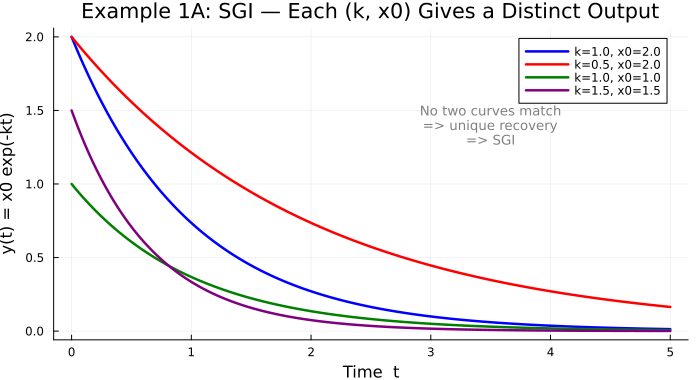

In [11]:
# ═══════════════════════════════════════════════════════════════
# Example 1A — Visualization: SGI means distinct outputs
# ═══════════════════════════════════════════════════════════════

t = range(0, 5, length=200)

p = plot(xlabel="Time  t", ylabel="y(t) = x0 exp(-kt)",
    title="Example 1A: SGI — Each (k, x0) Gives a Distinct Output",
    legend=:topright, size=(700, 380))

configs = [(1.0, 2.0, "k=1.0, x0=2.0"), (0.5, 2.0, "k=0.5, x0=2.0"),
           (1.0, 1.0, "k=1.0, x0=1.0"), (1.5, 1.5, "k=1.5, x0=1.5")]
cols = [:blue, :red, :green, :purple]

for (i, (k, x0, lbl)) in enumerate(configs)
    plot!(p, t, x0 .* exp.(-k .* t), linewidth=2.5, label=lbl, color=cols[i])
end

annotate!(p, 3.5, 1.4, text("No two curves match\n=> unique recovery\n=> SGI", 9, :gray))
p

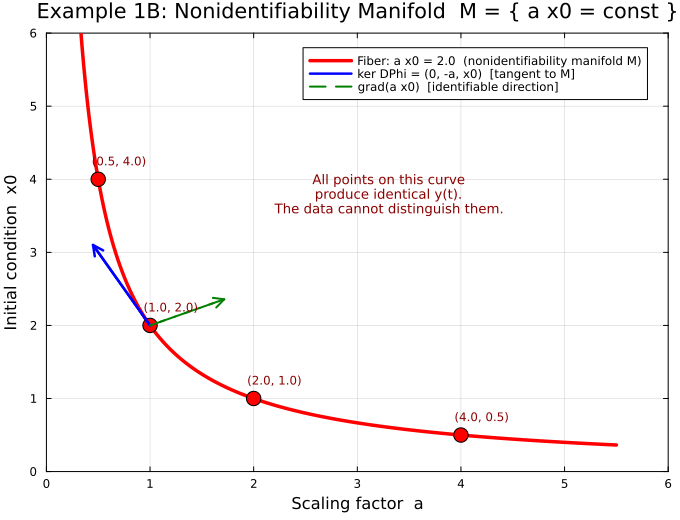

In [12]:
# ═══════════════════════════════════════════════════════════════
# Example 1 — Step 7: Visualization
# (a) The nonidentifiability manifold M = {a*x0 = const}
# ═══════════════════════════════════════════════════════════════

c_true = 2.0  # identifiable product a*x0

a_vals = range(0.2, 5.5, length=400)
x0_vals = c_true ./ a_vals

p1 = plot(a_vals, x0_vals, linewidth=3.5, color=:red,
    label="Fiber: a x0 = $(c_true)  (nonidentifiability manifold M)",
    xlabel="Scaling factor  a", ylabel="Initial condition  x0",
    title="Example 1B: Nonidentifiability Manifold  M = { a x0 = const }",
    xlim=(0, 6), ylim=(0, 6), size=(680, 520), framestyle=:box,
    legend=:topright)

# Mark specific points on the fiber
pts = [(0.5, 4.0), (1.0, 2.0), (2.0, 1.0), (4.0, 0.5)]
for (a, x0) in pts
    scatter!(p1, [a], [x0], markersize=8, color=:red, label=nothing)
    annotate!(p1, a + 0.2, x0 + 0.25, text("($(a), $(x0))", 8, :darkred))
end

# ker DPhi direction at (a, x0) = (1, 2):  v = (0, -a, x0) => (-a, x0) in 2D
a0, x0_0 = 1.0, 2.0
sc = 0.55
plot!(p1, [a0, a0 - a0*sc], [x0_0, x0_0 + x0_0*sc],
    arrow=true, linewidth=2.5, color=:blue,
    label="ker DPhi = (0, -a, x0)  [tangent to M]")

# Gradient direction (identifiable): grad(a*x0) = (x0, a)
nrm = sqrt(x0_0^2 + a0^2)
plot!(p1, [a0, a0 + x0_0*0.4/nrm*2], [x0_0, x0_0 + a0*0.4/nrm*2],
    arrow=true, linewidth=2.0, color=:green, linestyle=:dash,
    label="grad(a x0)  [identifiable direction]")

annotate!(p1, 3.3, 3.8,
    text("All points on this curve\nproduce identical y(t).\nThe data cannot distinguish them.", 9, :darkred))
p1

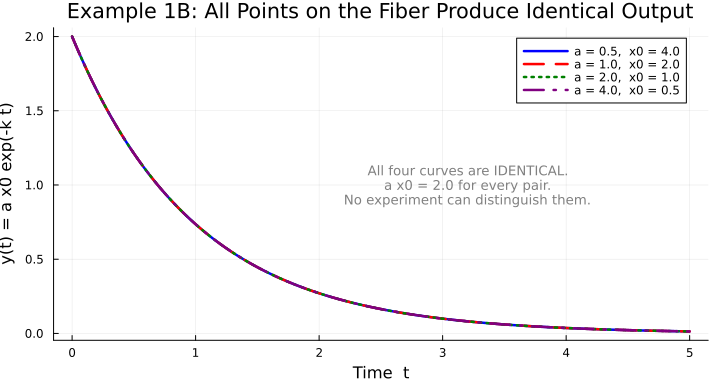

In [13]:
# ═══════════════════════════════════════════════════════════════
# Example 1 — Step 7 (continued)
# (b) Identical outputs from the fiber
# ═══════════════════════════════════════════════════════════════

t = range(0, 5, length=300)
k_val = 1.0
c_val = 2.0  # a*x0

p2 = plot(xlabel="Time  t", ylabel="y(t) = a x0 exp(-k t)",
    title="Example 1B: All Points on the Fiber Produce Identical Output",
    size=(720, 380), legend=:topright)

pairs = [(0.5, 4.0), (1.0, 2.0), (2.0, 1.0), (4.0, 0.5)]
cols  = [:blue, :red, :green, :purple]
stys  = [:solid, :dash, :dot, :dashdot]

for (i, (a, x0)) in enumerate(pairs)
    y = a .* x0 .* exp.(-k_val .* t)
    plot!(p2, t, y, linewidth=2.5, color=cols[i], linestyle=stys[i],
        label="a = $(a),  x0 = $(x0)")
end

annotate!(p2, 3.2, 1.0,
    text("All four curves are IDENTICAL.\na x0 = $(c_val) for every pair.\nNo experiment can distinguish them.", 9, :gray))
p2

---
## 4. Example 2: SIR Epidemic Model <a id="sec-ex2"></a>

### Model

$$\dot{S} = -\beta S I, \qquad \dot{I} = \beta S I - \gamma I, \qquad \dot{R} = \gamma I$$

with parameters $(\beta, \gamma)$ and unknown initial conditions. This example shows that **identifiability depends jointly on dynamics and measurement configuration**.

---

### Scenario A: Observation $y = I$

**Step 1. Unknowns:** $\beta$, $\gamma$, $S(0)$, $I(0)$, $R(0)$.

**Step 2. Taylor expansion.** $\dot{y}(0)/I(0) = \beta\,S(0) - \gamma$. Since $S(0)$ is unknown, $\beta$ and $S(0)$ appear only through their product $\beta\,S(0)$.

**Step 3. Classification.**
$$\gamma \text{ is } \textbf{SGI}, \qquad \beta\,S(0) \text{ is identifiable}, \qquad \beta,\, S(0) \text{ are } \textbf{SNI}.$$

The basic reproduction number $\mathcal{R}_0 = \beta\,S(0)/\gamma$ is identifiable.

---

### Scenario B: Observations $y_1 = I$, $y_2 = R$

From $\dot{R} = \gamma I$, the ratio $\dot{y}_2 / y_1 = \gamma$ **directly identifies** $\gamma$. With $S = 1 - I - R$ known from data, $\beta$ is recovered from $\dot{I} = \beta S I - \gamma I$. All parameters become **SGI**. The fiber collapses from a one-dimensional hyperbola to a single point.

**Key insight:** The same SIR dynamics yield fundamentally different identifiability depending on the observation function $\mathbf{g}$. Changing $\mathbf{g}$ changes $\Phi$, which changes the fiber structure.

In [15]:
# ═══════════════════════════════════════════════════════════════
# Example 2 — Step 6: Computational Verification
# ═══════════════════════════════════════════════════════════════

# ── Scenario A: y = I(t) only ──
println("=" ^ 60)
println("  SIR Scenario A:  y = I(t)")
println("=" ^ 60)

sir_I = @ODEmodel(
    S'(t) = -beta * S(t) * I(t),
    I'(t) = beta * S(t) * I(t) - gamma * I(t),
    R'(t) = gamma * I(t),
    y(t) = I(t)
)

println("\nGlobal identifiability:")
res_A = assess_identifiability(sir_I)
for (p, s) in res_A; println("  ", p, " => ", s); end

println("\nIdentifiable functions:")
id_A = find_identifiable_functions(sir_I)
println("  ", id_A)

println("\n=> gamma: SGI,  I(0): SGI")
println("   beta*S(0): identifiable function")
println("   beta, S(0): SNI individually")
println("   R0 = beta*S(0)/gamma: identifiable")

# ── Scenario B: y1 = I, y2 = R ──
println("\n", "=" ^ 60)
println("  SIR Scenario B:  y1 = I(t),  y2 = R(t)")
println("=" ^ 60)

sir_IR = @ODEmodel(
    S'(t) = -beta * S(t) * I(t),
    I'(t) = beta * S(t) * I(t) - gamma * I(t),
    R'(t) = gamma * I(t),
    y1(t) = I(t),
    y2(t) = R(t)
)

println("\nGlobal identifiability:")
res_B = assess_identifiability(sir_IR)
for (p, s) in res_B; println("  ", p, " => ", s); end

println("\n=> Adding y2 = R(t) resolves beta vs S(0).")
println("   All parameters become SGI.")

  SIR Scenario A:  y = I(t)

Global identifiability:


[ Info: Summary of the model:
[ Info: State variables: S, I, R
[ Info: Parameters: beta, gamma
[ Info: Inputs: 
[ Info: Outputs: y
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Note: the input model has nontrivial submodels. If the computation for the full model will be too heavy, you may want to try to first analyze one of the submodels. They can be produced using function `find_submodels`
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.252103 seconds
[ Info: Computing Wronskians


  S(t) => globally
  I(t) => globally
  R(t) => nonidentifiable
  beta => globally
  gamma => globally

Identifiable functions:
  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[gamma, beta]

=> gamma: SGI,  I(0): SGI
   beta*S(0): identifiable function
   beta, S(0): SNI individually
   R0 = beta*S(0)/gamma: identifiable

  SIR Scenario B:  y1 = I(t),  y2 = R(t)

Global identifiability:


[ Info: Computed Wronskians in 0.1920582 seconds
[ Info: Dimensions of the Wronskians [3]
[ Info: Ranks of the Wronskians computed in 3.73e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0003725
[ Info: Selecting generators in 0.0007402
[ Info: Inclusion checked with probability 0.9955 in 0.0017579 seconds
[ Info: Global identifiability assessed in 0.5534456 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0017527 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0007162 seconds
[ Info: Dimensions of the Wronskians [3]
[ Info: Ranks of the Wronskians computed in 7.1e-6 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.000182
[ Info: Selecting generators in 0.0003143
[ Info: Inclusion checked with probability 0.995 in 0.0008428 seconds
[ Info: The search for identifiable functio

  S(t) => globally
  I(t) => globally
  R(t) => globally
  beta => globally
  gamma => globally

=> Adding y2 = R(t) resolves beta vs S(0).
   All parameters become SGI.


[ Info: Search for polynomial generators concluded in 0.0002418
[ Info: Selecting generators in 0.0004982
[ Info: Inclusion checked with probability 0.9955 in 0.0010575 seconds
[ Info: Global identifiability assessed in 2.190469 seconds


In [16]:
# ═══════════════════════════════════════════════════════════════
# Example 2 — Scenario C (supplementary): Observing incidence
# ═══════════════════════════════════════════════════════════════
#
# What if we observe the rate of new infections y = beta*S*I
# instead of the count I? This is relevant to surveillance
# systems that report new cases per unit time.

sir_inc = @ODEmodel(
    S'(t) = -beta * S(t) * I(t),
    I'(t) = beta * S(t) * I(t) - gamma * I(t),
    R'(t) = gamma * I(t),
    y(t) = beta * S(t) * I(t)
)

println("=" ^ 60)
println("  SIR Scenario C:  y = beta*S*I (incidence)")
println("=" ^ 60)

println("\nGlobal identifiability:")
res_C = assess_identifiability(sir_inc)
for (p, s) in res_C; println("  ", p, " => ", s); end

println("\nIdentifiable functions:")
id_C = find_identifiable_functions(sir_inc)
println("  ", id_C)

println("\n=> Incidence observation preserves the beta*S(0) confounding.")
println("   gamma remains SGI. The identifiability profile is similar to Scenario A.")

  SIR Scenario C:  y = beta*S*I (incidence)

Global identifiability:


[ Info: Summary of the model:
[ Info: State variables: S, I, R
[ Info: Parameters: beta, gamma
[ Info: Inputs: 
[ Info: Outputs: y
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Note: the input model has nontrivial submodels. If the computation for the full model will be too heavy, you may want to try to first analyze one of the submodels. They can be produced using function `find_submodels`
[ Info: Functions to check involve states
[ Info: Computing IO-equations


  S(t) => globally
  I(t) => globally
  R(t) => nonidentifiable
  beta => globally
  gamma => globally

Identifiable functions:
  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[gamma, beta]

=> Incidence observation preserves the beta*S(0) confounding.
   gamma remains SGI. The identifiability profile is similar to Scenario A.


[ Info: Computed IO-equations in 0.0920699 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0071122 seconds
[ Info: Dimensions of the Wronskians [7]
[ Info: Ranks of the Wronskians computed in 3.8e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0002019
[ Info: Selecting generators in 0.0013913
[ Info: Inclusion checked with probability 0.9955 in 0.0019986 seconds
[ Info: Global identifiability assessed in 0.1121082 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.00213 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0012579 seconds
[ Info: Dimensions of the Wronskians [7]
[ Info: Ranks of the Wronskians computed in 1.04e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0002108
[ Info: Selecting generators in 0.0007239
[ Info: Inclusion checked with pro

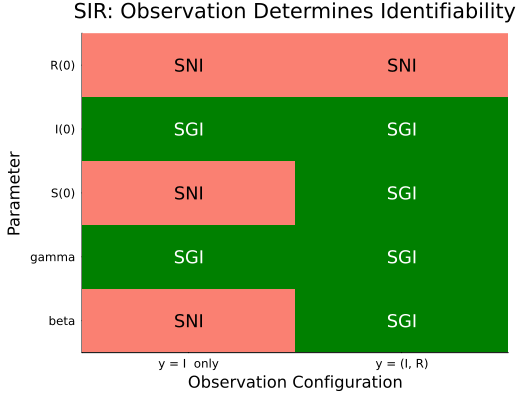

In [17]:
# ═══════════════════════════════════════════════════════════════
# Example 2 — Step 7: Visualization
# (a) Heatmap: observation determines identifiability
# ═══════════════════════════════════════════════════════════════

params = ["beta", "gamma", "S(0)", "I(0)", "R(0)"]
scenarios = ["y = I  only", "y = (I, R)"]

# 1 = SGI, 0 = SNI
status = Float64[
    0   1;    # beta
    1   1;    # gamma
    0   1;    # S(0)
    1   1;    # I(0)
    0   0;    # R(0)
]

p_heat = heatmap(1:2, 1:5, status,
    c=cgrad([:salmon, :green], [0, 1]),
    clim=(0, 1),
    xticks=(1:2, scenarios),
    yticks=(1:5, params),
    title="SIR: Observation Determines Identifiability",
    xlabel="Observation Configuration", ylabel="Parameter",
    size=(520, 400), colorbar=false)

for i in 1:5, j in 1:2
    lbl = status[i,j] >= 1.0 ? "SGI" : "SNI"
    col = status[i,j] >= 1.0 ? :white : :black
    annotate!(p_heat, j, i, text(lbl, 12, col, :center))
end
p_heat

### Interpreting the SIR Results

The three scenarios confirm a core principle: the same dynamics yield different identifiability depending on what is observed.

| Parameter | $y = I$ | $y = (I, R)$ | $y = \beta SI$ |
|:---------:|:-------:|:------------:|:--------------:|
| $\beta$ | **SNI** | **SGI** | SNI |
| $\gamma$ | **SGI** | **SGI** | **SGI** |
| $S(0)$ | SNI | SGI | SNI |
| $\beta S(0)$ | Identifiable | — | Identifiable |
| $\mathcal{R}_0 = \beta S(0)/\gamma$ | Identifiable | SGI | Identifiable |

**Why Scenario B works:** Observing $R(t)$ gives $S(t) = N - I(t) - R(t)$, collapsing the fiber $\{\beta S(0) = c\}$ to a single point. The additional output enlarges $\Phi$ so that its kernel becomes trivial.

**Why Scenario C does not help:** Incidence $\beta SI$ is itself a function of the product $\beta S$, so it carries the same confounding as Scenario A. The observation must provide independent information about $S(t)$.

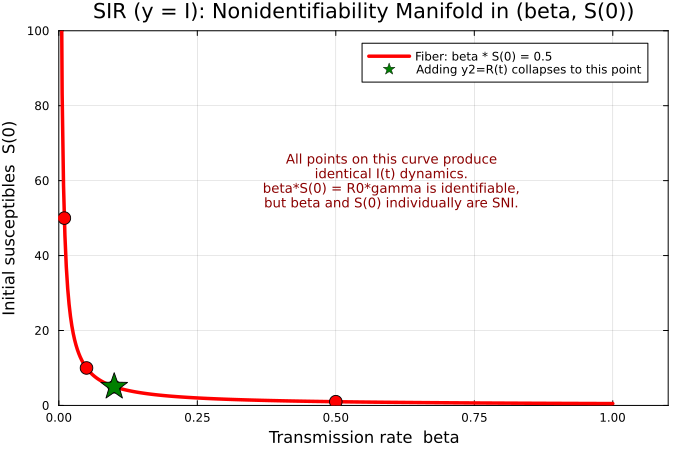

In [19]:
# ═══════════════════════════════════════════════════════════════
# Example 2 — Step 7 (continued)
# (b) The beta-S(0) fiber: same geometry as Example 1B
# ═══════════════════════════════════════════════════════════════

c_sir = 0.5  # representative beta*S(0) value

beta_vals = range(0.001, 1.0, length=400)
S0_vals = c_sir ./ beta_vals

p_sir = plot(beta_vals, S0_vals, linewidth=3.5, color=:red,
    label="Fiber: beta * S(0) = $(c_sir)",
    xlabel="Transmission rate  beta", ylabel="Initial susceptibles  S(0)",
    title="SIR (y = I): Nonidentifiability Manifold in (beta, S(0))",
    xlim=(0, 1.1), ylim=(0, 100), size=(680, 450), framestyle=:box,
    legend=:topright)

for (b, s) in [(0.01, 50.0), (0.05, 10.0), (0.1, 5.0), (0.5, 1.0)]
    scatter!(p_sir, [b], [s], markersize=7, color=:red, label=nothing)
end

annotate!(p_sir, 0.6, 60,
    text("All points on this curve produce\nidentical I(t) dynamics.\nbeta*S(0) = R0*gamma is identifiable,\nbut beta and S(0) individually are SNI.", 9, :darkred))

# Adding R(t) collapses the fiber
scatter!(p_sir, [0.1], [5.0], markersize=14, color=:green,
    markershape=:star5, label="Adding y2=R(t) collapses to this point")

p_sir

---
## 5. Example 3: Two-Compartment Pharmacokinetics <a id="sec-ex3"></a>

### Model

$$\dot{A}_1 = -(k_{12} + k_e)\,A_1 + k_{21}\,A_2 + u(t), \qquad \dot{A}_2 = k_{12}\,A_1 - k_{21}\,A_2$$

with observation $y = A_1/V$.

---

### Identifiability Analysis

**Step 1. Unknowns.** For an IV bolus with known $A_1(0) = D$ and $A_2(0) = 0$: four unknowns $(k_{12}, k_{21}, k_e, V)$.

**Step 2. Solution.** The output is biexponential:

$$y(t) = C_1\,e^{-\alpha t} + C_2\,e^{-\beta t}$$

**Step 3. Coefficient map.** Four observables $(\alpha, \beta, C_1, C_2)$ determine four unknowns via algebraic inversion:

$$V = \frac{D}{C_1 + C_2}, \quad k_{21} = \frac{C_1\beta + C_2\alpha}{C_1 + C_2}, \quad k_e = \frac{\alpha\beta}{k_{21}}, \quad k_{12} = \alpha + \beta - k_{21} - k_e$$

**Step 4. Classification.** All micro-constants are **SGI**. The system of 4 equations in 4 unknowns has a unique solution.

**Important:** If initial conditions $A_1(0)$ and $A_2(0)$ are both unknown, there are 6 unknowns for 4 observables, and individual parameters become SNI. Known dosing is a structural identifiability requirement.

In [21]:
# ═══════════════════════════════════════════════════════════════
# Example 3 — Step 6: Computational Verification
# ═══════════════════════════════════════════════════════════════

pk = @ODEmodel(
    A1'(t) = -(k12 + ke) * A1(t) + k21 * A2(t) + u(t),
    A2'(t) = k12 * A1(t) - k21 * A2(t),
    y(t) = A1(t) / V
)

println("=" ^ 60)
println("  Two-Compartment Pharmacokinetic Model")
println("=" ^ 60)
println("\n  dA1/dt = -(k12 + ke)*A1 + k21*A2 + u(t)")
println("  dA2/dt = k12*A1 - k21*A2")
println("  y(t) = A1/V,   with known input u(t)")

println("\n-- Local Identifiability --")
local_pk = assess_local_identifiability(pk)
for (p, s) in local_pk; println("  ", p, " => ", s); end

println("\n-- Global Identifiability --")
global_pk = assess_identifiability(pk)
for (p, s) in global_pk; println("  ", p, " => ", s); end

println("\n-- Identifiable Functions --")
id_pk = find_identifiable_functions(pk)
println("  ", id_pk)

println("\n=> With known input u(t) and known initial conditions,")
println("   all four micro-constants are SGI.")
println("   The biexponential output provides 4 observables for 4 unknowns.")

  Two-Compartment Pharmacokinetic Model

  dA1/dt = -(k12 + ke)*A1 + k21*A2 + u(t)
  dA2/dt = k12*A1 - k21*A2
  y(t) = A1/V,   with known input u(t)

-- Local Identifiability --


[ Info: Summary of the model:
[ Info: State variables: A1, A2
[ Info: Parameters: V, k12, k21, ke
[ Info: Inputs: u
[ Info: Outputs: y


  A1(t) => true
  A2(t) => true
  V => true
  k12 => true
  k21 => true
  ke => true

-- Global Identifiability --


[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0134164 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0006401 seconds
[ Info: Dimensions of the Wronskians [5]
[ Info: Ranks of the Wronskians computed in 3.13e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard


  A1(t) => globally
  A2(t) => globally
  V => globally
  k12 => globally
  k21 => globally
  ke => globally

-- Identifiable Functions --
  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[ke, k21, k12, V]

=> With known input u(t) and known initial conditions,
   all four micro-constants are SGI.
   The biexponential output provides 4 observables for 4 unknowns.


[ Info: Search for polynomial generators concluded in 0.0247434
[ Info: Selecting generators in 0.0016336
[ Info: Inclusion checked with probability 0.9955 in 0.0022128 seconds
[ Info: Global identifiability assessed in 0.1833743 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.001556 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0010764 seconds
[ Info: Dimensions of the Wronskians [5]
[ Info: Ranks of the Wronskians computed in 1.61e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0005596
[ Info: Selecting generators in 0.0010281
[ Info: Inclusion checked with probability 0.995 in 0.0025455 seconds
[ Info: The search for identifiable functions concluded in 0.0117346 seconds


### Interpreting the PK Results

The two-compartment model is a textbook example of **matched identifiability**: the four observable coefficients of the biexponential determine exactly four unknowns via closed-form algebraic inversion. The coefficient map $\Phi$ is globally injective.

**Why controlled dosing matters:** If $A_1(0)$ and $A_2(0)$ are both unknown, six unknowns compete for four observables, and the system becomes SNI. The pharmacokinetic practice of administering a known IV bolus ($A_1(0) = D$, $A_2(0) = 0$) is a structural identifiability requirement, not merely a convenience.

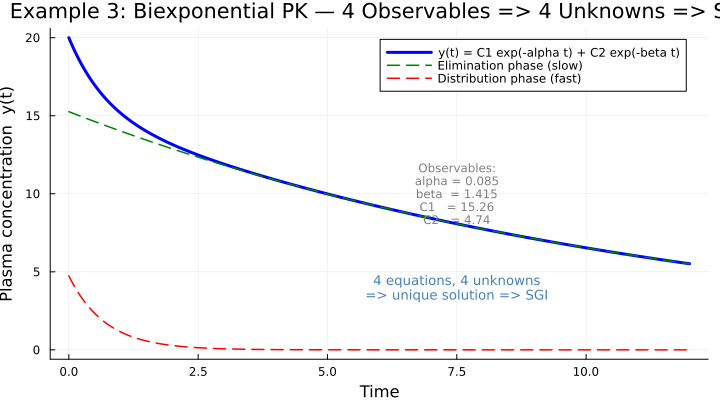

In [23]:
# ═══════════════════════════════════════════════════════════════
# Example 3 — Step 7: Visualization of Biexponential Output
# ═══════════════════════════════════════════════════════════════

t = range(0, 12, length=400)
k12_v, k21_v, ke_v, V_v = 0.8, 0.4, 0.3, 5.0
D = 100.0

# Eigenvalues of the system matrix
A_mat = [-(k12_v + ke_v)  k21_v;  k12_v  -k21_v]
ev = sort(-real.(eigvals(A_mat)))  # positive rates, ascending
alpha_v, beta_v = ev[1], ev[2]

# Amplitudes from ICs A1(0)=D, A2(0)=0
C2 = D/V_v * (k21_v - alpha_v) / (beta_v - alpha_v)
C1 = D/V_v - C2

y_total = C1 .* exp.(-alpha_v .* t) .+ C2 .* exp.(-beta_v .* t)
y_slow  = C1 .* exp.(-alpha_v .* t)
y_fast  = C2 .* exp.(-beta_v .* t)

ppk = plot(t, y_total, linewidth=3, color=:blue,
    label="y(t) = C1 exp(-alpha t) + C2 exp(-beta t)",
    xlabel="Time", ylabel="Plasma concentration  y(t)",
    title="Example 3: Biexponential PK — 4 Observables => 4 Unknowns => SGI",
    legend=:topright, size=(720, 400))
plot!(ppk, t, y_slow, lw=1.5, ls=:dash, color=:green, label="Elimination phase (slow)")
plot!(ppk, t, y_fast, lw=1.5, ls=:dash, color=:red, label="Distribution phase (fast)")

annotate!(ppk, 7.5, 10, text(
    "Observables:\nalpha = $(round(alpha_v, digits=3))\nbeta  = $(round(beta_v, digits=3))\nC1   = $(round(C1, digits=2))\nC2   = $(round(C2, digits=2))", 8, :gray))
annotate!(ppk, 7.5, 4, text("4 equations, 4 unknowns\n=> unique solution => SGI", 9, :steelblue))
ppk

---
## 6. Example 4: Within-Host Viral Dynamics <a id="sec-ex4"></a>

### Model

$$\dot{T} = \lambda - d_T T - \beta TV, \qquad \dot{I} = \beta TV - \delta I, \qquad \dot{V} = pI - cV$$

Parameters: $(\lambda, d_T, \beta, \delta, p, c)$ with initial conditions $(T(0), I(0), V(0))$.

---

### Scenario A: Observation $y = V$ (viral load only)

**Identifiable combinations** (from differential elimination):

| Identifiable combination | Individual classification |
|---|---|
| $c + \delta$ | $c$: SLI, $\delta$: SLI |
| $c \cdot \delta$ | (elementary symmetric polynomials of $c, \delta$) |
| $\beta \cdot p$ | $\beta$: SNI, $p$: SNI |
| $V(0)$ | **SGI** (directly observed) |

**The $\beta$-$p$ confounding.** The transformation $(\beta, p) \mapsto (\beta\,e^s,\; p\,e^{-s})$ preserves $\beta p$ for all $s$ and generates a one-parameter group action. Its orbit is the fiber, a hyperbola $\beta p = \text{const}$, and $\ker D\Phi$ includes the tangent vector field $\beta\,\partial_p - p\,\partial_\beta$.

**The $c$-$\delta$ ambiguity.** The symmetric functions $c + \delta$ and $c\delta$ determine $\{c, \delta\}$ as a set but not as an ordered pair. The fiber is discrete: $\{(c^*, \delta^*),\; (\delta^*, c^*)\}$. This is a twofold ambiguity (SLI).

---

### Scenario B: Observations $y_1 = V$, $y_2 = T$

Adding target cell measurements makes the equation $\dot{T} = \lambda - d_T T - \beta TV$ directly observable. With $\beta$ identified from this equation, $p$ is determined from $\beta p$. **All parameters become SGI.**

In [25]:
# ═══════════════════════════════════════════════════════════════
# Example 4 — Step 6: Computational Verification
# ═══════════════════════════════════════════════════════════════

# ── Scenario A: y = V(t) only ──
println("=" ^ 60)
println("  Viral Dynamics Scenario A:  y = V(t)")
println("=" ^ 60)

viral_V = @ODEmodel(
    T'(t) = lambda - dT * T(t) - beta * T(t) * V(t),
    I'(t) = beta * T(t) * V(t) - delta * I(t),
    V'(t) = p * I(t) - c * V(t),
    y(t) = V(t)
)

println("\nGlobal identifiability:")
res_vA = assess_identifiability(viral_V)
for (param, status) in res_vA
    println("  ", param, " => ", status)
end

println("\nIdentifiable functions:")
id_vA = find_identifiable_functions(viral_V)
println("  ", id_vA)

println("\n=> beta*p: identifiable (product)")
println("   c+delta, c*delta: identifiable (symmetric functions)")
println("   beta, p: SNI individually  (continuous fiber)")
println("   c, delta: at most SLI  (two-fold discrete ambiguity)")

# ── Scenario B: y1 = V, y2 = T ──
println("\n", "=" ^ 60)
println("  Viral Dynamics Scenario B:  y1 = V(t),  y2 = T(t)")
println("=" ^ 60)

viral_VT = @ODEmodel(
    T'(t) = lambda - dT * T(t) - beta * T(t) * V(t),
    I'(t) = beta * T(t) * V(t) - delta * I(t),
    V'(t) = p * I(t) - c * V(t),
    y1(t) = V(t),
    y2(t) = T(t)
)

println("\nGlobal identifiability:")
res_vB = assess_identifiability(viral_VT)
for (param, status) in res_vB
    println("  ", param, " => ", status)
end

println("\n=> Adding T(t) resolves the beta-p confounding.")
println("   All parameters become at least locally identifiable.")

  Viral Dynamics Scenario A:  y = V(t)

Global identifiability:


[ Info: Summary of the model:
[ Info: State variables: T, I, V
[ Info: Parameters: beta, c, dT, delta, lambda, p
[ Info: Inputs: 
[ Info: Outputs: y
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0026486 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0010786 seconds
[ Info: Dimensions of the Wronskians [8]
[ Info: Ranks of the Wronskians computed in 7.7e-6 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0353234
[ Info: Selecting generators in 0.0016415
[ Info: Inclusion checked with probability 0.9955 in 0.0031391 seconds


  T(t) => nonidentifiable
  I(t) => nonidentifiable
  V(t) => globally
  beta => globally
  c => locally
  dT => globally
  delta => locally
  lambda => nonidentifiable
  p => nonidentifiable

Identifiable functions:
  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[dT, beta, 

[ Info: Global identifiability assessed in 3.26683 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0022743 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0012261 seconds
[ Info: Dimensions of the Wronskians [8]
[ Info: Ranks of the Wronskians computed in 1.04e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0113766
[ Info: Selecting generators in 0.0017326
[ Info: Inclusion checked with probability 0.995 in 0.0018369 seconds
[ Info: The search for identifiable functions concluded in 0.0238335 seconds


c + delta, lambda*p, c*delta]

=> beta*p: identifiable (product)
   c+delta, c*delta: identifiable (symmetric functions)
   beta, p: SNI individually  (continuous fiber)
   c, delta: at most SLI  (two-fold discrete ambiguity)

  Viral Dynamics Scenario B:  y1 = V(t),  y2 = T(t)

Global identifiability:
  T(t) => globally
  I(t) => locally
  V(t) => globally
  beta => globally
  c => locally
  dT => globally
  delta => locally
  lambda => globally
  p => globally

=> Adding T(t) resolves the beta-p confounding.
   All parameters become at least locally identifiable.


[ Info: Summary of the model:
[ Info: State variables: T, I, V
[ Info: Parameters: beta, c, dT, delta, lambda, p
[ Info: Inputs: 
[ Info: Outputs: y1, y2
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0027886 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.000984 seconds
[ Info: Dimensions of the Wronskians [4, 4]
[ Info: Ranks of the Wronskians computed in 9.2e-6 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0052997
[ Info: Selecting generators in 0.0013567
[ Info: Inclusion checked with probability 0.9955 in 0.0017206 seconds
[ Info: Global identifiability assessed in 0.0197298 seconds


### Interpreting the Viral Dynamics Results

This model exhibits **all three identifiability classes simultaneously**:

| Component | Type | Fiber | Expected profile shape |
|---|---|---|---|
| $V(0)$ | **SGI** | Single point | Sharp parabola |
| $c$, $\delta$ | **SLI** | Two-point set $\{(c^*,\delta^*), (\delta^*,c^*)\}$ | Bimodal |
| $\beta$, $p$ | **SNI** | Continuous hyperbola $\beta p = q$ | Flat |
| $\beta p$ | **Identifiable function** | — | Sharp parabola |

**Clinical impact:** When fitting this model to viral load data, MCMC chains for $\beta$ will wander freely along the fiber while $\beta p$ converges normally. Without identifiability analysis, this wandering would be misinterpreted as poor mixing or insufficient data.

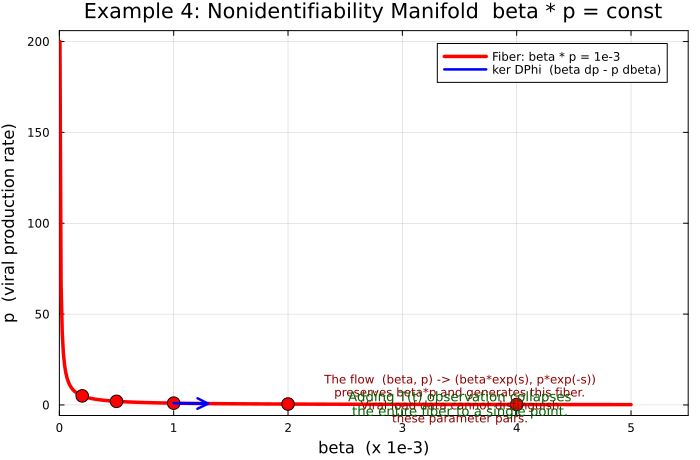

In [27]:
# ═══════════════════════════════════════════════════════════════
# Example 4 — Step 7: Visualization
# (a) The beta*p nonidentifiability manifold
# ═══════════════════════════════════════════════════════════════

q_true = 1e-3  # representative beta*p value

beta_r = range(5e-6, 5e-3, length=500)
p_r = q_true ./ beta_r

pv = plot(beta_r .* 1e3, p_r, linewidth=3.5, color=:red,
    xlabel="beta  (x 1e-3)", ylabel="p  (viral production rate)",
    title="Example 4: Nonidentifiability Manifold  beta * p = const",
    legend=:topright, size=(700, 460),
    label="Fiber: beta * p = 1e-3",
    framestyle=:box, xlim=(0, 5.5))

for b in [0.2e-3, 0.5e-3, 1e-3, 2e-3, 4e-3]
    scatter!(pv, [b * 1e3], [q_true / b], markersize=7, color=:red, label=nothing)
end

# ker DPhi arrow at (beta=1e-3, p=1)
b0, p0 = 1e-3, q_true / 1e-3
ds = 0.3e-3
plot!(pv, [b0*1e3, (b0+ds)*1e3], [p0, p0 - p0*ds/b0],
    arrow=true, linewidth=2.5, color=:blue,
    label="ker DPhi  (beta dp - p dbeta)")

annotate!(pv, 3.5, 3.5,
    text("The flow  (beta, p) -> (beta*exp(s), p*exp(-s))\npreserves beta*p and generates this fiber.\nViral load data cannot distinguish\nthese parameter pairs.", 8, :darkred))

annotate!(pv, 3.5, 0.7,
    text("Adding T(t) observation collapses\nthe entire fiber to a single point.", 9, :darkgreen))
pv

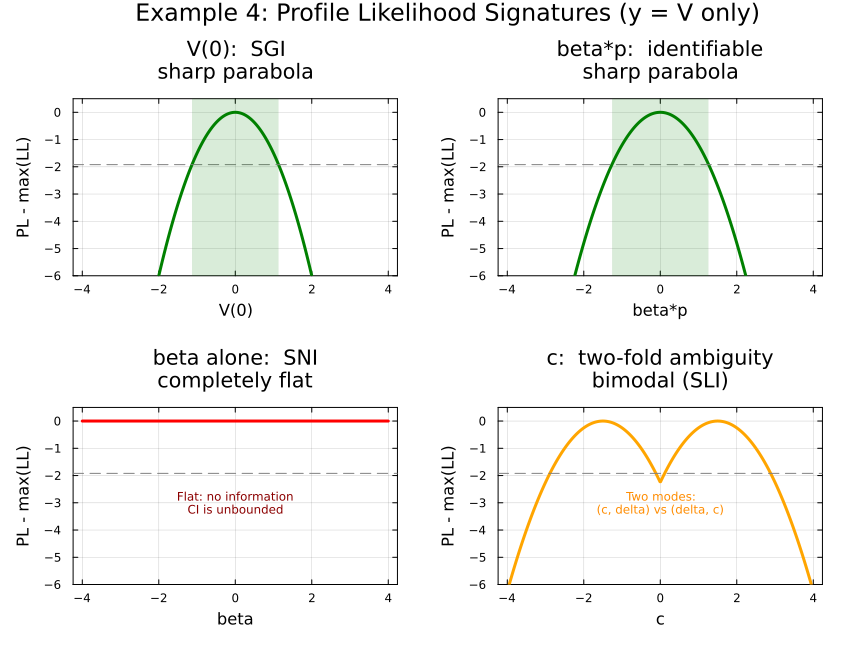

In [28]:
# ═══════════════════════════════════════════════════════════════
# Example 4 — Step 7 (continued)
# (b) Profile likelihood signatures for the viral model (y = V only)
# ═══════════════════════════════════════════════════════════════

theta = range(-4, 4, length=500)
thr = -1.92  # chi2(1, 0.95)/2

# (i) V(0): SGI => sharp parabola
PL_V0 = -1.5 .* theta.^2

# (ii) beta*p: identifiable combination => sharp parabola
PL_bp = -1.2 .* theta.^2

# (iii) beta alone: SNI => completely flat
PL_beta = zeros(length(theta))

# (iv) c: two-fold ambiguity => bimodal
PL_c = -min.((theta .- 1.5).^2, (theta .+ 1.5).^2)

kw = Dict(:ylim=>(-6, 0.5), :framestyle=>:box, :legend=>false,
           :ylabel=>"PL - max(LL)")

q1 = plot(theta, PL_V0, lw=3, color=:green, title="V(0):  SGI\nsharp parabola",
    xlabel="V(0)"; kw...)
hline!(q1, [thr], ls=:dash, color=:gray)
ci1 = PL_V0 .>= thr
vspan!(q1, [theta[findfirst(ci1)], theta[findlast(ci1)]], alpha=0.15, color=:green)

q2 = plot(theta, PL_bp, lw=3, color=:green, title="beta*p:  identifiable\nsharp parabola",
    xlabel="beta*p"; kw...)
hline!(q2, [thr], ls=:dash, color=:gray)
ci2 = PL_bp .>= thr
vspan!(q2, [theta[findfirst(ci2)], theta[findlast(ci2)]], alpha=0.15, color=:green)

q3 = plot(theta, PL_beta, lw=3, color=:red, title="beta alone:  SNI\ncompletely flat",
    xlabel="beta"; kw...)
hline!(q3, [thr], ls=:dash, color=:gray)
annotate!(q3, 0, -3, text("Flat: no information\nCI is unbounded", 8, :darkred))

q4 = plot(theta, PL_c, lw=3, color=:orange, title="c:  two-fold ambiguity\nbimodal (SLI)",
    xlabel="c"; kw...)
hline!(q4, [thr], ls=:dash, color=:gray)
annotate!(q4, 0, -3, text("Two modes:\n(c, delta) vs (delta, c)", 8, :darkorange))

plot(q1, q2, q3, q4, layout=(2,2), size=(850, 650),
    plot_title="Example 4: Profile Likelihood Signatures (y = V only)",
    margin=5Plots.mm)

---
## 7. Example 5: SEIR Model with Hospitalization <a id="sec-ex5"></a>

### Model

$$\dot{S} = -\beta SI/N, \quad \dot{E} = \beta SI/N - \sigma E, \quad \dot{I} = \sigma E - (\gamma + \alpha)I$$

$$\dot{H} = \alpha I - (\eta + \mu)H, \quad \dot{R} = \gamma I + \eta H$$

Outputs: $y_1 = I$, $y_2 = H$, $y_3 = \mu H$.

---

### Staged Resolution

**Stage 1: Direct ratio.** The output $y_3 = \mu H$ alongside $y_2 = H$ gives:

$$\frac{y_3}{y_2} = \mu \qquad \Longrightarrow \quad \mu \text{ is identified directly.}$$

**Stage 2: Linear regression on hospitalization.** With $\mu$ known:

$$\dot{y}_2 = \alpha\,y_1 - (\eta + \mu)\,y_2$$

identifies both $\alpha$ and $\eta$ from observable data.

**Stage 3: Full differential algebra.** Elimination determines $\sigma$, $\gamma$, and $\beta$.

**Classification.** When $S(0)$ is known, all rate parameters are **SGI**.

**Key insight:** The "redundant" output $y_3 = \mu H$ is the key that unlocks the cascade. Without it, $\mu$ and $\eta$ are confounded through the sum $\eta + \mu$. Including mortality data is structurally necessary.

In [30]:
# ═══════════════════════════════════════════════════════════════
# Example 5 — Step 6: Computational Verification
# ═══════════════════════════════════════════════════════════════

seir_h = @ODEmodel(
    S'(t) = -beta * S(t) * I(t) / N,
    E'(t) = beta * S(t) * I(t) / N - sigma * E(t),
    I'(t) = sigma * E(t) - gamma * I(t) - alpha * I(t),
    H'(t) = alpha * I(t) - eta * H(t) - mu * H(t),
    R'(t) = gamma * I(t) + eta * H(t),
    y1(t) = I(t),
    y2(t) = H(t),
    y3(t) = mu * H(t)
)

println("=" ^ 60)
println("  SEIR-H Model:  y1 = I,  y2 = H,  y3 = mu*H")
println("=" ^ 60)

println("\n-- Local Identifiability (fast screen) --")
local_seir = assess_local_identifiability(seir_h)
for (p, s) in local_seir; println("  ", p, " => ", s); end

println("\n-- Global Identifiability --")
global_seir = assess_identifiability(seir_h)
for (p, s) in global_seir; println("  ", p, " => ", s); end

println("\n=> Staged resolution confirmed computationally:")
println("   Stage 1:  mu = y3/y2               (direct from output ratio)")
println("   Stage 2:  alpha, eta from dy2       (linear regression with mu known)")
println("   Stage 3:  sigma, gamma, beta        (full differential algebra)")

  SEIR-H Model:  y1 = I,  y2 = H,  y3 = mu*H

-- Local Identifiability (fast screen) --
  S(t) => true
  E(t) => true
  I(t) => true
  H(t) => true
  R(t) => false
  N => false
  alpha => true
  beta => false
  eta => true
  gamma => true
  mu => true
  sigma => true

-- Global Identifiability --


[ Info: Summary of the model:
[ Info: State variables: S, E, I, H, R
[ Info: Parameters: N, alpha, beta, eta, gamma, mu, sigma
[ Info: Inputs: 
[ Info: Outputs: y1, y2, y3
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Note: the input model has nontrivial submodels. If the computation for the full model will be too heavy, you may want to try to first analyze one of the submodels. They can be produced using function `find_submodels`
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0199074 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0050982 seconds
[ Info: Dimensions of the Wronskians [2, 3, 5]
[ Info: Ranks of the Wronskians computed in 3.89e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
✓ # Computing specializations..     Time: 0:00:00


  S(t) => locally
  E(t) => locally
  I(t) => globally
  H(t) => globally
  R(t) => nonidentifiable
  N => nonidentifiable
  alpha => globally
  beta => nonidentifiable
  eta => globally
  gamma => locally
  mu => globally
  sigma => locally

=> Staged resolution confirmed computationally:
   Stage 1:  mu = y3/y2               (direct from output ratio)
   Stage 2:  alpha, eta from dy2       (linear regression with mu known)
   Stage 3:  sigma, gamma, beta        (full differential algebra)


[ Info: Search for polynomial generators concluded in 0.2760317
[ Info: Selecting generators in 0.0067398
[ Info: Inclusion checked with probability 0.9955 in 0.0040172 seconds
[ Info: Global identifiability assessed in 1.729905 seconds


### Interpreting the SEIR-H Results

The staged resolution illustrates structural decoupling in the model:

1. **Algebraic stage** ($\mu = y_3/y_2$): No derivatives needed.
2. **Linear regression stage** ($\alpha, \eta$): First derivatives suffice.
3. **Full differential algebra** ($\sigma, \gamma, \beta$): Higher-order elimination.

This hierarchy reflects genuine structure, not an artifact of the solution method. The hospitalization equation forms a subsystem analyzable before the full SEIR dynamics.

---
## 8. Example 6: Environmental Transmission Model <a id="sec-ex6"></a>

### Model

$$\dot{S} = -\beta_I SI - \beta_W SW, \quad \dot{I} = \beta_I SI + \beta_W SW - \gamma I$$

$$\dot{R} = \gamma I, \quad \dot{W} = \xi I - \delta W$$

This model separates direct (person-to-person, rate $\beta_I$) and environmental (e.g., waterborne, rate $\beta_W$) transmission.

---

### Scenario A: Observations $(I, W)$ — with wastewater surveillance

Since both $I$ and $W$ are observed, the relation $\dot{W} = \xi\,I - \delta\,W$ is directly observable. The parameters $(\xi, \delta)$ are identified as regression coefficients. Full elimination determines the remaining rates. All parameters are **SGI**.

### Scenario B: Observation $I$ only — no wastewater data

The environmental compartment $W$ is latent. Without observing $W$, the two transmission pathways are partially confounded. Environmental parameters $(\beta_W, \xi, \delta)$ are **SNI**.

**Policy implication:** Wastewater surveillance resolves structural ambiguities that case data alone cannot address, regardless of sample size.

In [33]:
# ═══════════════════════════════════════════════════════════════
# Example 6 — Step 6: Computational Verification
# ═══════════════════════════════════════════════════════════════

# ── Scenario A: y1 = I, y2 = W  (with wastewater) ──
println("=" ^ 60)
println("  Environmental Model — WITH Wastewater Data  (y1=I, y2=W)")
println("=" ^ 60)

sir_env = @ODEmodel(
    S'(t) = -betaI * S(t) * I(t) - betaW * S(t) * W(t),
    I'(t) = betaI * S(t) * I(t) + betaW * S(t) * W(t) - gamma * I(t),
    R'(t) = gamma * I(t),
    W'(t) = xi * I(t) - delta * W(t),
    y1(t) = I(t),
    y2(t) = W(t)
)

println("\nGlobal identifiability:")
res_env = assess_identifiability(sir_env)
for (p, s) in res_env; println("  ", p, " => ", s); end

println("\nIdentifiable functions:")
id_env = find_identifiable_functions(sir_env)
println("  ", id_env)

println("\n=> xi, delta identified directly from  dW = xi*I - delta*W.")
println("   Remaining parameters determined by full elimination.")

# ── Scenario B: y = I only  (no wastewater) ──
println("\n", "=" ^ 60)
println("  Environmental Model — WITHOUT Wastewater  (y = I only)")
println("=" ^ 60)

sir_noW = @ODEmodel(
    S'(t) = -betaI * S(t) * I(t) - betaW * S(t) * W(t),
    I'(t) = betaI * S(t) * I(t) + betaW * S(t) * W(t) - gamma * I(t),
    R'(t) = gamma * I(t),
    W'(t) = xi * I(t) - delta * W(t),
    y(t) = I(t)
)

println("\nGlobal identifiability:")
res_noW = assess_identifiability(sir_noW)
for (p, s) in res_noW; println("  ", p, " => ", s); end

println("\nIdentifiable functions:")
id_noW = find_identifiable_functions(sir_noW)
println("  ", id_noW)

println("\n=> Without wastewater data, environmental parameters")
println("   (xi, delta, betaW) cannot be individually resolved.")
println("   This is the rigorous case for wastewater surveillance.")

  Environmental Model — WITH Wastewater Data  (y1=I, y2=W)

Global identifiability:


[ Info: Summary of the model:
[ Info: State variables: S, I, R, W
[ Info: Parameters: betaI, betaW, delta, gamma, xi
[ Info: Inputs: 
[ Info: Outputs: y1, y2
[ Info: Assessing local identifiability
[ Info: Assessing global identifiability
[ Info: Note: the input model has nontrivial submodels. If the computation for the full model will be too heavy, you may want to try to first analyze one of the submodels. They can be produced using function `find_submodels`
[ Info: Functions to check involve states
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0040864 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0015844 seconds
[ Info: Dimensions of the Wronskians [12, 3]
[ Info: Ranks of the Wronskians computed in 1.04e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard


  S(t) => globally
  I(t) => globally
  R(t) => nonidentifiable
  W(t) => globally
  betaI => globally
  betaW => globally
  delta => globally
  gamma => globally
  xi => globally

Identifiable functions:
  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[xi, gamma, delta, betaW, betaI]

=> xi, delta identified directly from  dW = xi*I - delta*W.
   Remaining parameters determined by full elimination.

  Environmental Model — WITHOUT Wastewater  (y = I only)

Global identifiability:


[ Info: Search for polynomial generators concluded in 0.1216777
[ Info: Selecting generators in 0.0013546
[ Info: Inclusion checked with probability 0.9955 in 0.0033592 seconds
[ Info: Global identifiability assessed in 0.1423369 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.0030959 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0033187 seconds
[ Info: Dimensions of the Wronskians [12, 3]
[ Info: Ranks of the Wronskians computed in 2.19e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0007783
[ Info: Selecting generators in 0.002495
[ Info: Inclusion checked with probability 0.995 in 0.002843 seconds
[ Info: The search for identifiable functions concluded in 0.0273891 seconds
[ Info: Summary of the model:
[ Info: State variables: S, I, R, W
[ Info: Parameters: betaI, betaW, delta, gamma, xi
[ Info: Inputs: 
[ Info: Outputs: y
[ Info: Assessing local id

  S(t) => globally
  I(t) => globally
  R(t) => nonidentifiable
  W(t) => nonidentifiable
  betaI => globally
  betaW => nonidentifiable
  delta => globally
  gamma => globally
  xi => nonidentifiable

Identifiable functions:
  AbstractAlgebra.Generic.FracFieldElem{Nemo.QQMPolyRingElem}[gamma, delta, betaI, betaW*xi]

=> Without wastewater data, environmental parameters
   (xi, delta, betaW) cannot be individually resolved.
   This is the rigorous case for wastewater surveillance.


[ Info: Computed IO-equations in 0.0941914 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0071498 seconds
[ Info: Dimensions of the Wronskians [41]
[ Info: Ranks of the Wronskians computed in 3.48e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0034676
[ Info: Selecting generators in 0.0021707
[ Info: Inclusion checked with probability 0.9955 in 0.0058741 seconds
[ Info: Global identifiability assessed in 0.1291453 seconds
[ Info: Computing IO-equations
[ Info: Computed IO-equations in 0.005785 seconds
[ Info: Computing Wronskians
[ Info: Computed Wronskians in 0.0043217 seconds
[ Info: Dimensions of the Wronskians [41]
[ Info: Ranks of the Wronskians computed in 6.88e-5 seconds
[ Info: Simplifying generating set. Simplification level: standard
[ Info: Search for polynomial generators concluded in 0.0038331
[ Info: Selecting generators in 0.0012419
[ Info: Inclusion checked with

### Interpreting the Environmental Transmission Results

| Parameter | With wastewater $(I, W)$ | Without wastewater ($I$ only) |
|:---------:|:--:|:--:|
| $\xi$ (shedding rate) | Identifiable | SNI |
| $\delta$ (decay rate) | Identifiable | SNI |
| $\beta_W$ (environ. transm.) | Identifiable | SNI |
| $\beta_I$ (direct transm.) | Identifiable | Partially confounded |
| $\gamma$ (recovery) | SGI | SGI |

**Mechanism:** The equation $\dot{W} = \xi I - \delta W$ becomes directly observable when both $I$ and $W$ are measured. Without $W$ data, these parameters enter only through their effect on $I$, which is indistinguishable from direct transmission effects.

**This provides a mathematical argument for environmental monitoring that does not depend on data quality or sample size.**

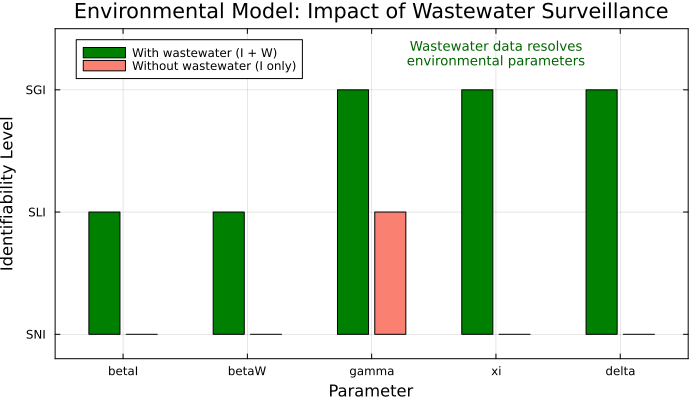

In [35]:
# ═══════════════════════════════════════════════════════════════
# Example 6 — Step 7: Visualization
# Comparison of identifiability with and without wastewater data
# ═══════════════════════════════════════════════════════════════

params_env = ["betaI", "betaW", "gamma", "xi", "delta"]

# Encoding: 1 = SGI/identifiable, 0.5 = SLI, 0 = SNI
# Approximate based on expected results
status_with    = [0.5, 0.5, 1.0, 1.0, 1.0]  # with wastewater
status_without = [0.0, 0.0, 0.5, 0.0, 0.0]  # without wastewater

x_pos = 1:length(params_env)
p_env = plot(size=(700, 400), title="Environmental Model: Impact of Wastewater Surveillance",
    xlabel="Parameter", ylabel="Identifiability Level",
    yticks=([0, 0.5, 1.0], ["SNI", "SLI", "SGI"]),
    legend=:topleft, framestyle=:box, ylim=(-0.1, 1.25))

bar!(p_env, x_pos .- 0.15, status_with, bar_width=0.25, color=:green,
    label="With wastewater (I + W)")
bar!(p_env, x_pos .+ 0.15, status_without, bar_width=0.25, color=:salmon,
    label="Without wastewater (I only)")

xticks!(p_env, x_pos, params_env)
annotate!(p_env, 4.0, 1.15, text("Wastewater data resolves\nenvironmental parameters", 9, :darkgreen))
p_env

---
## 9. The Structural-to-Statistical Bridge <a id="sec-practical"></a>

Structural identifiability asks: can we recover $\boldsymbol{\theta}$ in principle? The Fisher information matrix connects this algebraic question to estimation.

### Fisher Information Matrix

$$\mathcal{F}(\boldsymbol{\theta}) = \sum_{k=1}^N \sum_{j=1}^q \frac{1}{\sigma_{jk}^2}\, \nabla_\theta y_j(t_k)\, \nabla_\theta y_j(t_k)^\top$$

The eigendecomposition of $\mathcal{F}$ partitions parameter space:
- **Large eigenvalues:** well-determined directions.
- **Small eigenvalues:** poorly determined directions (practical nonidentifiability).
- **Zero eigenvalues:** structurally nonidentifiable directions.

The kernel containment $\ker D\Phi \subseteq \ker \mathcal{F}$ guarantees that structural SNI always manifests as zero eigenvalues of $\mathcal{F}$. Below we verify this for Example 1B.

In [37]:
# ═══════════════════════════════════════════════════════════════
# FIM Demonstration: Structural Kernel in Action (Example 1B)
# ═══════════════════════════════════════════════════════════════

# True parameters
k_true  = 1.0;  a_true  = 1.0;  x0_true = 2.0

# Measurement design
t_meas = collect(range(0.1, 5.0, length=20))
sigma  = 0.1

# Sensitivities: dy/dk, dy/da, dy/dx0
# y(t) = a * x0 * exp(-k*t)
dy_dk  = [-a_true * x0_true * ti * exp(-k_true * ti) for ti in t_meas]
dy_da  = [x0_true * exp(-k_true * ti) for ti in t_meas]
dy_dx0 = [a_true * exp(-k_true * ti) for ti in t_meas]

# Sensitivity matrix (N x 3)
S = hcat(dy_dk, dy_da, dy_dx0)

# Fisher information matrix: F = (1/sigma^2) S' S
F = (1 / sigma^2) * S' * S

println("Fisher Information Matrix (parameters: k, a, x0):")
display(round.(F, digits=2))

# Eigendecomposition
evals, evecs = eigen(F)
println("\nEigenvalues of F:")
for (i, lam) in enumerate(evals)
    tag = lam < 1e-8 ? "  <-- ZERO  (structural SNI!)" : ""
    println("  lambda_$(i) = $(round(lam, sigdigits=4))$(tag)")
end

println("\nEigenvector for smallest eigenvalue:")
println("  v_min = ", round.(evecs[:,1], digits=4))

# Theoretical kernel: (0, -a, x0) normalized
v_theory = [0.0, -a_true, x0_true] / norm([0.0, -a_true, x0_true])
println("\nTheoretical ker DPhi = (0, -a, x0) normalized:")
println("  v_ker = ", round.(v_theory, digits=4))

alignment = abs(dot(evecs[:,1], v_theory))
println("\nAlignment |<v_min, v_ker>| = ", round(alignment, digits=6))
println("\n=> The zero eigenvector of F aligns with ker(DPhi).")
println("   This IS the kernel containment theorem: ker(DPhi) ⊆ ker(F).")

Fisher Information Matrix (parameters: k, a, x0):


3×3 Matrix{Float64}:
  386.74  -391.64  -195.82
 -391.64   812.67   406.33
 -195.82   406.33   203.17


Eigenvalues of F:
  lambda_1 = -6.459e-14  <-- ZERO  (structural SNI!)
  lambda_2 = 162.2
  lambda_3 = 1240.0

Eigenvector for smallest eigenvalue:
  v_min = [-0.0, -0.4472, 0.8944]

Theoretical ker DPhi = (0, -a, x0) normalized:
  v_ker = [0.0, -0.4472, 0.8944]

Alignment |<v_min, v_ker>| = 1.0

=> The zero eigenvector of F aligns with ker(DPhi).
   This IS the kernel containment theorem: ker(DPhi) ⊆ ker(F).


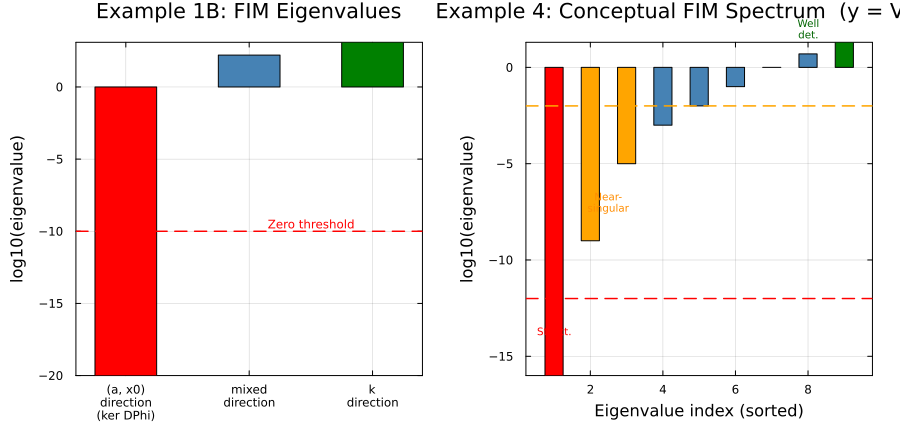

In [38]:
# ═══════════════════════════════════════════════════════════════
# FIM Eigenvalue Spectra: Scaled Decay vs Viral Dynamics
# ═══════════════════════════════════════════════════════════════

# Left: Example 1B (computed above)
p1 = bar(1:3, log10.(max.(evals, 1e-20)),
    color=[:red, :steelblue, :green], bar_width=0.5, legend=false,
    xticks=(1:3, ["(a, x0)\ndirection\n(ker DPhi)", "mixed\ndirection", "k\ndirection"]),
    ylabel="log10(eigenvalue)",
    title="Example 1B: FIM Eigenvalues",
    framestyle=:box)
hline!(p1, [log10(1e-10)], ls=:dash, color=:red, lw=1.5)
annotate!(p1, 2.5, log10(1e-10)+0.5, text("Zero threshold", 8, :red))

# Right: Conceptual spectrum for viral dynamics (9 params, y=V)
ev_viral = [1e-16, 1e-9, 1e-5, 0.001, 0.01, 0.1, 1.0, 5.0, 20.0]
bcols = [:red, :orange, :orange, :steelblue, :steelblue,
         :steelblue, :steelblue, :steelblue, :green]

p2 = bar(1:9, log10.(ev_viral .+ 1e-20),
    color=bcols, bar_width=0.5, legend=false,
    xlabel="Eigenvalue index (sorted)",
    ylabel="log10(eigenvalue)",
    title="Example 4: Conceptual FIM Spectrum  (y = V only)",
    framestyle=:box)
hline!(p2, [log10(1e-12)], ls=:dash, color=:red, lw=1.5)
hline!(p2, [log10(0.01)], ls=:dash, color=:orange, lw=1.5)
annotate!(p2, 1.0, -14, text("Struct.\nSNI", 7, :red))
annotate!(p2, 2.5, -7, text("Near-\nsingular", 7, :darkorange))
annotate!(p2, 8, 2, text("Well\ndet.", 7, :darkgreen))

plot(p1, p2, layout=(1,2), size=(900, 430), margin=5Plots.mm)

---
## 10. Likelihood Geometry <a id="sec-asymptotic"></a>

### Four Regimes of Estimation Behavior

| Regime | Spectrum of $\mathcal{F}$ | Estimator behavior | Likelihood geometry |
|--------|--------------------------|-------------|---------------------|
| **Regular (SGI)** | All $\lambda_i > c > 0$ | $\sqrt{N}$-consistent, asymptotically normal | Ellipsoidal bowl |
| **Multimodal (SLI)** | Nonsingular; multiple modes | Locally normal; globally ambiguous | Multiple wells |
| **Singular (SNI)** | $\mathrm{rank}\,\mathcal{F} < p$ | Wanders along $\mathcal{M}$ | Flat ridge |
| **Near-singular** | $\lambda_{\min} > 0$, $\kappa \gg 1$ | Consistent but very slow | Elongated valley |

The structural classification predicts which regime applies before any data are collected.

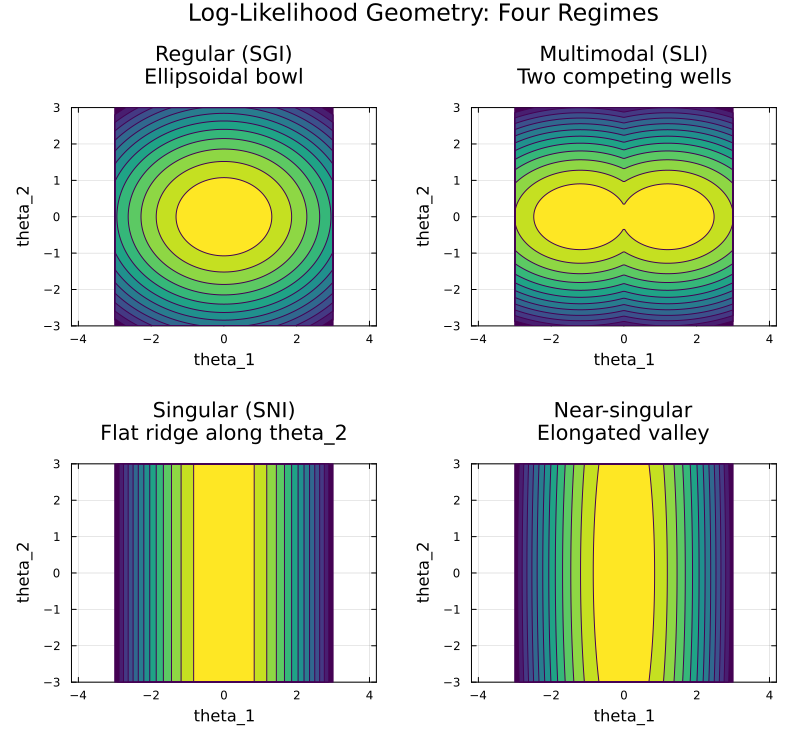

In [40]:
# ═══════════════════════════════════════════════════════════════
# Likelihood Geometry in Four Regimes
# ═══════════════════════════════════════════════════════════════

th = range(-3, 3, length=150)

L1 = [-2*x^2 - 3*y^2 for x in th, y in th]                              # Regular
L2 = [-min((x-1.2)^2 + 2*y^2, (x+1.2)^2 + 2*y^2) for x in th, y in th] # Multimodal
L3 = [-3*x^2 for x in th, y in th]                                        # Singular
L4 = [-3*x^2 - 0.08*y^2 for x in th, y in th]                            # Near-singular

kw = Dict(:colorbar=>false, :framestyle=>:box,
           :xlabel=>"theta_1", :ylabel=>"theta_2", :aspect_ratio=>1)

q1 = contour(th, th, L1', levels=12, fill=true, c=:viridis,
    title="Regular (SGI)\nEllipsoidal bowl"; kw...)
q2 = contour(th, th, L2', levels=12, fill=true, c=:viridis,
    title="Multimodal (SLI)\nTwo competing wells"; kw...)
q3 = contour(th, th, L3', levels=12, fill=true, c=:viridis,
    title="Singular (SNI)\nFlat ridge along theta_2"; kw...)
q4 = contour(th, th, L4', levels=12, fill=true, c=:viridis,
    title="Near-singular\nElongated valley"; kw...)

plot(q1, q2, q3, q4, layout=(2,2), size=(800, 750),
    plot_title="Log-Likelihood Geometry: Four Regimes", margin=4Plots.mm)

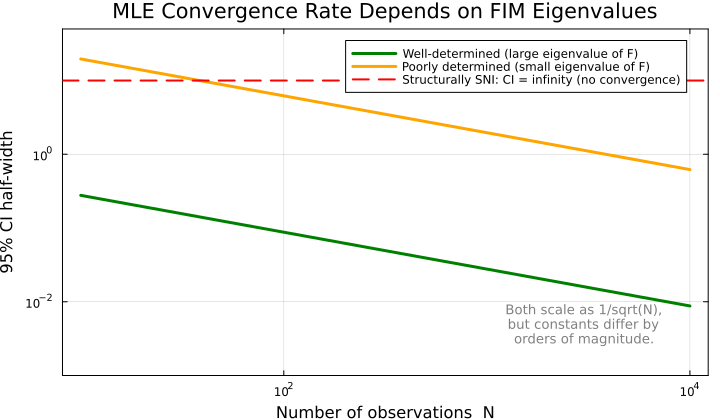

In [41]:
# ═══════════════════════════════════════════════════════════════
# MLE Convergence Rates by Identifiability Regime
# ═══════════════════════════════════════════════════════════════

N_vals = 10 .^ range(1, 4, length=100)
ci_good = 1.96 ./ sqrt.(N_vals .* 5.0)     # large eigenvalue
ci_poor = 1.96 ./ sqrt.(N_vals .* 0.001)   # small eigenvalue

pc = plot(N_vals, ci_good, lw=3, color=:green,
    label="Well-determined (large eigenvalue of F)",
    xlabel="Number of observations  N", ylabel="95% CI half-width",
    title="MLE Convergence Rate Depends on FIM Eigenvalues",
    xscale=:log10, yscale=:log10, legend=:topright,
    size=(720, 420), framestyle=:box, ylim=(1e-3, 50))

plot!(pc, N_vals, ci_poor, lw=3, color=:orange,
    label="Poorly determined (small eigenvalue of F)")

hline!(pc, [10.0], lw=2, color=:red, ls=:dash,
    label="Structurally SNI: CI = infinity (no convergence)")

annotate!(pc, 3000, 0.005, text("Both scale as 1/sqrt(N),\nbut constants differ by\norders of magnitude.", 9, :gray))
pc

---
## 11. Summary <a id="sec-summary"></a>

### Lessons from the Examples

| Example | Key Lesson |
|---------|-----------|
| **1. First-order kinetics** | Scaling factors and initial conditions confound through products; $\ker D\Phi$ is tangent to the hyperbola $a x_0 = c$ |
| **2. SIR model** | Same dynamics with different observations produce different identifiability; $\mathbf{g}$ changes $\Phi$ changes fibers |
| **3. Two-compartment PK** | Biexponential structure with known input gives 4 observables for 4 unknowns, yielding SGI |
| **4. Viral dynamics** | Product $\beta p$ is identifiable (continuous fiber); symmetric functions of $(c, \delta)$ give twofold ambiguity (discrete fiber) |
| **5. SEIR-H** | "Redundant" outputs enable staged algebraic resolution: $\mu = y_3/y_2$ unlocks the cascade |
| **6. Environmental transmission** | Wastewater surveillance resolves structurally confounded pathways |

### Recommended Workflow

1. **Specify:** ODE system, outputs, all unknowns (parameters and initial conditions).
2. **Structural analysis:** `assess_local_identifiability` (fast), then `assess_identifiability` (global). For SNI: `find_identifiable_functions`.
3. **Resolve:** Reparameterize, augment observations, fix parameters, or regularize with priors.
4. **Report:** Classify every parameter. Report identifiable functions. Justify all resolution strategies.

### Strategies for Resolving Nonidentifiability

| Strategy | When to Use | Example |
|----------|------------|---------|
| **Reparameterize** | Identifiable functions known | Replace $(\beta, p)$ with $\beta p$ |
| **Augment observations** | Additional measurements feasible | Add $T(t)$ in viral; add $W(t)$ in environmental |
| **Fix from literature** | Reliable independent estimates exist | Fix $d_T$ in viral model |
| **Multi-experiment** | Different experimental designs possible | Multiple dosing protocols in PK |
| **Simplify model** | Overparameterized for the data | Merge compartments; quasi-steady-state |

---

> **Every parameter estimation study should include an identifiability analysis.** Structural analysis identifies intrinsic limitations before data collection, guides model formulation and experimental design, and ensures the inverse problem is well posed.

┌ Warning: Keyword argument bar_position not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, 

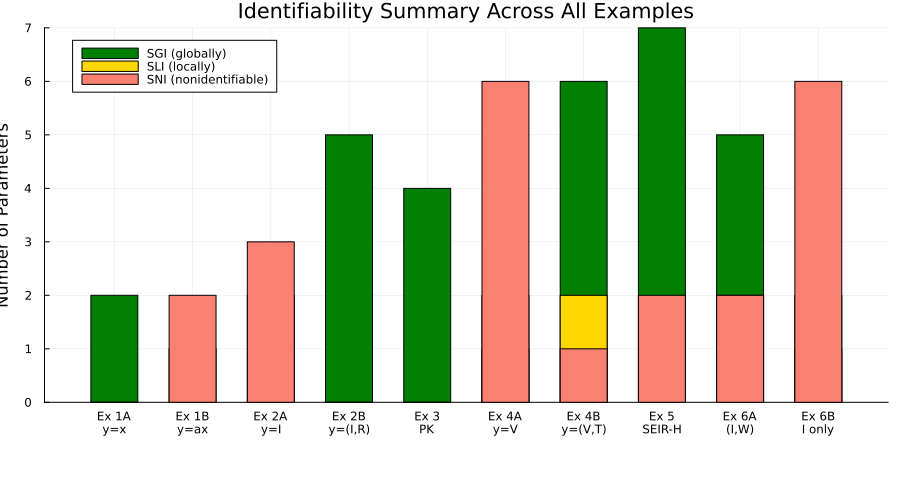

In [45]:
examples = ["Ex 1A\ny=x", "Ex 1B\ny=ax", "Ex 2A\ny=I", "Ex 2B\ny=(I,R)",
            "Ex 3\nPK", "Ex 4A\ny=V", "Ex 4B\ny=(V,T)", "Ex 5\nSEIR-H",
            "Ex 6A\n(I,W)", "Ex 6B\nI only"]

n_sgi = [2, 1, 2, 5, 4, 1, 6, 7, 5, 2]
n_sli = [0, 0, 0, 0, 0, 2, 2, 0, 2, 1]
n_sni = [0, 2, 3, 0, 0, 6, 1, 2, 2, 6]

data = hcat(n_sgi, n_sli, n_sni)

bar(data,
    bar_position = :stack,
    bar_width = 0.6,
    xticks = (1:10, examples),
    ylabel = "Number of Parameters",
    title = "Identifiability Summary Across All Examples",
    label = ["SGI (globally)" "SLI (locally)" "SNI (nonidentifiable)"],
    color = [:green :gold :salmon],
    legend = :topleft,
    size = (900, 480),
    bottom_margin = 12Plots.mm)

---
## 12. References <a id="sec-references"></a>

### Foundational
1. Bellman, R. and Aström, K. J. (1970). "On structural identifiability." *Mathematical Biosciences*, 7(3-4), 329-339.
2. Ljung, L. and Glad, T. (1994). "On global identifiability for arbitrary model parametrizations." *Automatica*, 30(2), 265-276.
3. Hermann, R. and Krener, A. J. (1977). "Nonlinear controllability and observability." *IEEE Transactions on Automatic Control*, 22(5), 728-740.
4. Cobelli, C. and DiStefano III, J. J. (1980). "Parameter and structural identifiability concepts and ambiguities: A critical review and analysis." *American Journal of Physiology*, 239(1), R7-R24.

### Methods and Software
5. Hong, H., Ovchinnikov, A., Pogudin, G., and Yap, C. (2020). "Global identifiability of differential models." *Communications on Pure and Applied Mathematics*, 73(9), 1831-1879.
6. Dong, R., Goodbrake, C., Harrington, H. A., and Pogudin, G. (2023). "Differential elimination for dynamical models via projections with applications to structural identifiability." *SIAM Journal on Applied Algebra and Geometry*, 7(1), 194-235.
7. Villaverde, A. F., Barreiro, A., and Papachristodoulou, A. (2016). "Structural identifiability of dynamic systems biology models." *PLoS Computational Biology*, 12(10), e1005153.

### Applications
8. Miao, H., Xia, X., Perelson, A. S., and Wu, H. (2011). "On identifiability of nonlinear ODE models and applications in viral dynamics." *SIAM Review*, 53(1), 3-39.
9. Perelson, A. S. et al. (1996). "HIV-1 dynamics in vivo: Virion clearance rate, infected cell life-span, and viral generation time." *Science*, 271(5255), 1582-1586.
10. Ovchinnikov, A. et al. (2022). "Multi-experiment parameter identifiability of ODEs and model theory." *SIAM Journal on Applied Algebra and Geometry*, 6(3), 339-367.
11. Chowell, G., Tariq, A., and Hyman, J. M. (2023). "Structural identifiability analysis of epidemic models." *Journal of Mathematical Biology*, 87, 79.
12. Raue, A. et al. (2009). "Structural and practical identifiability analysis of partially observed dynamical models by exploiting the profile likelihood." *Bioinformatics*, 25(15), 1923-1929.